## This notebook explores a basic jerk analysis for COVOBS

In [1]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') ) #This line needs to point to whereever the jerks module has been compiled.
from jerks import jerks

In [4]:
# import the dataset
import chaosmagpy as cp
model = cp.load_CovObs_txtfile('/Users/earpwl/OneDrive - University of Leeds/home/models/COVOBS.x2/COV-OBS.x2-int')  # load model txt-file

In [8]:
time = np.arange(1840., 2020.+1, 1)  # decimal years
mjd = cp.data_utils.dyear_to_mjd(time, leap_year=False)

coeffs = model.synth_coeffs(mjd, nmax=13, deriv=0)


#### Plot a picture of Br at the CMB at epoch 2000 to check that everything works

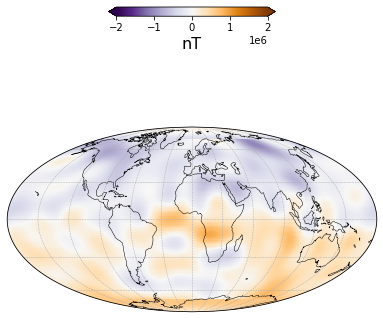

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

index = np.argmin(abs(time-2000))

coeffs_single_epoch = coeffs[index,:]

radius = 3485.

theta = np.linspace(1., 179., 181)
phi = np.linspace(-180., 180, 361)
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs_single_epoch, radius, theta, phi, grid=True,nmax=13)

limit = 2e6  # nT colorbar limit

# create figure
fig = plt.figure(figsize=(16, 10))

# make array of axes
axes = []
gs = fig.add_gridspec(3,3)
axes.append(plt.subplot(gs[1, :], projection=ccrs.Mollweide()))

for ax in axes:
    pc = ax.pcolormesh(phi, 90. - theta, Br, cmap='PuOr_r', vmin=-limit,
                       vmax=limit, transform=ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5, linestyle='dashed',
                 ylocs=np.linspace(-90, 90, num=7),  # parallels
                 xlocs=np.linspace(-180, 180, num=13))  # meridians
    ax.coastlines(linewidth=0.5)

# inset axes into global map and move upwards
cax = inset_axes(axes[-1], width="45%", height="5%", loc='upper center',
                 borderpad=-12)

# use last artist for the colorbar
clb = plt.colorbar(pc, cax=cax, extend='both', orientation='horizontal')
clb.set_label('nT', fontsize=16)

plt.subplots_adjust(top=0.785, bottom=0.015, left=0.008,
                    right=0.992, hspace=0.0, wspace=0.0)

# Analysis

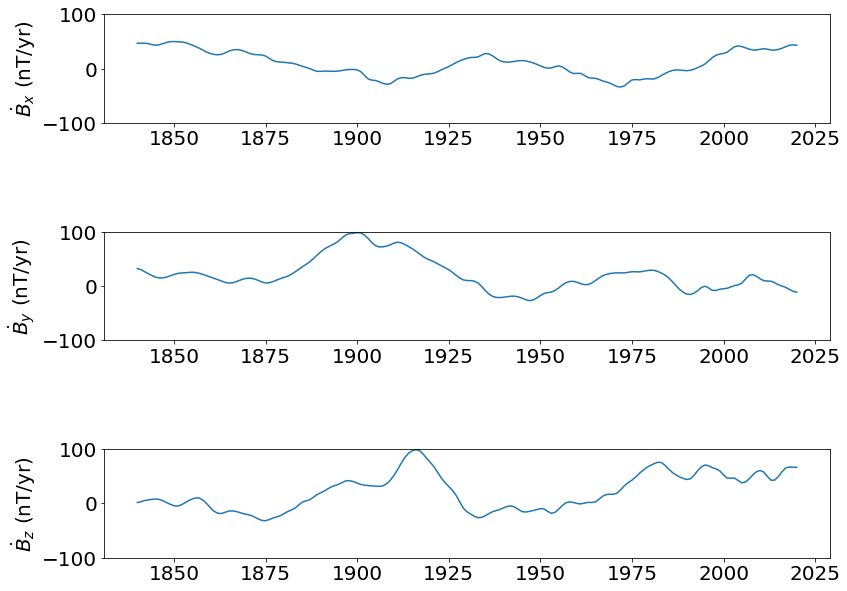

In [23]:
# plot SV series at theta = 90, phi = 45 
radius = 6371.
theta = 90
phi = 45

coeffs = model.synth_coeffs(mjd, nmax=13, deriv=0)


# sample every year
time_yearly = time

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,10) )
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-100,100)
ax1.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax2.set_ylim(-100,100)
ax2.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

#ax2.set_title(r'$d{B_Y}/dt$')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-100,100)
ax3.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
plt.savefig('COVOBS_plot1.pdf')

#### Run jerk finder on using a 10% relative error on 400 year interval (400 data).

In [24]:
run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in    

jerk_data_save =np.zeros( (K_MAX*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save  = np.zeros(3, dtype=int)
N_CP_hist_save = np.zeros( (K_MAX-K_MIN+1,3), dtype=int)

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = SV.min() 
    SV_MAX = SV.max()
    
    
    relative_sigmas = np.array([0.08, 0.02, 0.08])

    sigmas = np.array([ (SV.max() - SV.min())*relative_sigmas[0],\
                (TIMES_MAX - TIMES_MIN)*relative_sigmas[1],\
                   (SV.max() - SV.min())*relative_sigmas[2]],dtype = float)


    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX-K_MIN+1, dtype=int)
    # jerks:
    jerk_data = np.zeros( (K_MAX *(NSAMPLE-burn_in)//THIN,2),dtype=float )
    size_jerk_data = 0

    #saved history for animations
    jerk_history = np.zeros( ((NSAMPLE-burn_in)//THIN,2), dtype=int)
    model_history = np.zeros( (discretise_size, (NSAMPLE-burn_in)//THIN),dtype=float)

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data, \
    model_history, jerk_history) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, 
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    jerk_data_save[:,:,i] = jerk_data
    size_jerk_data_save[i] = size_jerk_data
    N_CP_hist_save[:,i] = N_CP_hist
    print(i, Acceptance_rates)
    

0 [40.00510025 43.19877243 15.53104973 15.57329559]
1 [40.8368988  45.68891907 15.77244949 15.81596661]
2 [43.91389847 44.24033356 17.17053032 17.21763229]


KeyboardInterrupt: 

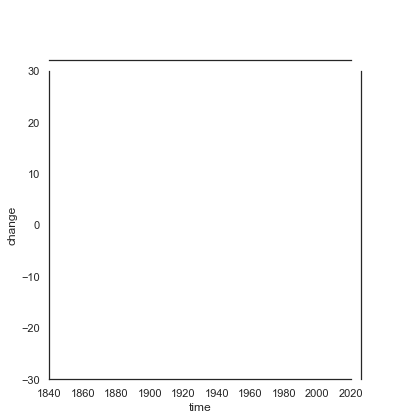

In [25]:
# Make kde image using seaborn:
import seaborn as sns
import pandas as pd
sns.set(style="white", color_codes=True)
joint_data = pd.DataFrame(data=jerk_data_save[0:size_jerk_data_save[0],:,0],columns=["time","change"])
joint_data = joint_data[ abs(joint_data["change"])<30 ]

# Draws a kernel density estimate (kde) of the pdf, using 10 equally spaced contour levels in probability density.

image = sns.jointplot(x=joint_data.time, y=joint_data.change, kind = 'kde', levels=10, ylim=[-30,30],xlim = [TIMES_MIN, TIMES_MAX], color="skyblue")

plt.xlabel('Time', fontsize=20);
plt.ylabel('Change in slope', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)


Text(0, 0.5, 'Change in slope')

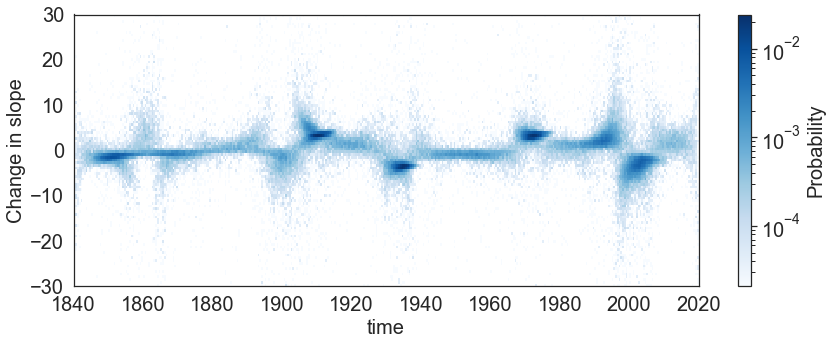

In [26]:
data_timing = jerk_data_save[0:size_jerk_data_save[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save[0],1,0]

import matplotlib.colors as colors
fig, ax = plt.subplots( figsize=(14,5))
counts, xedges, yedges, im = ax.hist2d(data_timing, data_amplitude, bins=(int(TIMES_MAX-TIMES_MIN)*2,100), range=[[TIMES_MIN,TIMES_MAX], [-30,30]],density=True, \
                                       cmap='Blues',norm=colors.LogNorm() )
cb = fig.colorbar(im, ax=ax)
cb.set_label("Probability", labelpad=6, size=20)
cb.ax.tick_params(labelsize=20)


ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('Change in slope', fontsize=20)


In [27]:
# Find jerks:

# 1. Find peaks in marginal histogram of changepoints satisfying criteria like min distance between jerks and jerk prominence, 
# 2. Find the subset of peaks for which the associated modal amplitude (from the 2d histogram) exceeds a certain threshold, label the peak a a jerk
# 3. Find the jerk width by seeing how far either side of the peak the 1d histogram drops to tau of the value at the peak.

# defaults:
# 
def find_jerks(data_timing, data_amplitude, number_time_bins, time_range, 
    number_amplitude_bins = 100, amplitude_range = [-50,50],
    jerk_min_amplitude = 1, min_distance = 4, \
    peak_prominence = 1, tau = 0.14):
    ''' 
    Function: find_jerks
    
    Returns a list of jerk attributes
    
        Parameters:
            data_timing (float, array): changepoint times
            data_amplitude: (float, array): changepoint slope changes
            number_time_bins (integer): number of bins in time
            time_range (list): start and end times
            
            Optional:
            jerk_min_amplitude (float): threshold for jerk identification
            min_distance (float): minimum distance between jerks
            prominence (float): prominence of jerks
            tau (float): threshold to characterise width of jerks
            
        Returns a list of jerk attributes in the form
            [jerk0, jerk1,...]
            where (for example) jerk0 is [jerk_time, jerk_amplitude, min_jerk_time, max_jerk_time]
            All four values are float; jerk_time is the most likely time for a jerk of amplitude jerk_amplitude, but it is uncertain with bounds given by min_jerk_time and max_jerk_time.
            
    Algorithm:
    1. Find peaks in marginal histogram of changepoints satisfying: min distance between jerks and jerk prominence. 
    2. Find the subset of peaks for which the associated slope change of maximum probability (from the 2d histogram) exceeds the threshold of jerk_min_amplitude.  See Scipy documentation for definition of prominence. 
    3. For these peaks ("jerks"), the jerk width is quantified by identifying the smallest time window that defines a drop in the 1d histogram of changepoint timing by tau on both sides. 
    If the changepoint histogram is Gaussian in shape, then 2 sigma corresponds to a drop in height of e^-2, or about 0.14. This defines then (roughly) a 95% credible interval.
    

    '''
    
    jerks_overall_info = []

    

    counts, xedges, yedges = np.histogram2d(data_timing, data_amplitude, bins=(number_time_bins,number_amplitude_bins), range=[time_range, amplitude_range])
    marginal_counts, marginal_xedges = np.histogram( data_timing, bins=number_time_bins, range=time_range)
    from scipy import signal

    peaks = signal.find_peaks(marginal_counts,distance=min_distance, prominence = peak_prominence * marginal_counts.mean() )  

    for peak_index in peaks[0]:
        jerk_info = np.zeros(4)
        index = counts[peak_index,:].argmax()  #find index corresponding to max probability
        jerk_amplitude = 0.5 * ( yedges[index] + yedges[index+1] )  #use the centre point of the bin
        if abs(jerk_amplitude) > jerk_min_amplitude:
            jerk_info[0] = 0.5 * ( marginal_xedges[peak_index] + marginal_xedges[peak_index+1] )  #use the centre point of the bin
            jerk_info[1] = jerk_amplitude

            min_jerk_time = marginal_xedges[0]
            max_jerk_time = marginal_xedges[-1]

            for i in range(peak_index,marginal_counts.shape[0]):  #count upwards in time to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    max_jerk_time = marginal_xedges[i]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the left edge of this bin.
                    break

            for i in range(peak_index,0,-1):  # count downwards to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    min_jerk_time = marginal_xedges[i+1]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the right edge of this bin.
                    break

            jerk_info[2], jerk_info[3] = min_jerk_time, max_jerk_time

            jerks_overall_info.append(jerk_info)
    return jerks_overall_info

    


In [28]:
data_timing = jerk_data_save[0:size_jerk_data_save[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save[0],1,0]

number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
time_range = [TIMES_MIN,TIMES_MAX]
jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range, \
                        number_amplitude_bins=200, tau=0.60)
    
print('{0:d} jerks found'.format(len(jerks_info)) )
for index,jerk in enumerate(jerks_info):
      print('Jerk {0:d} at time {1:f} with amplitude {4:f} with timing min/max of {2:f}, {3:f}'.\
            format(index,jerk[0], jerk[2], jerk[3], jerk[1]))
print('Bin width in jerk amplitude is ', (50--50)/200)    



6 jerks found
Jerk 0 at time 1850.750000 with amplitude -1.250000 with timing min/max of 1848.500000, 1854.500000
Jerk 1 at time 1910.250000 with amplitude 3.250000 with timing min/max of 1908.000000, 1912.000000
Jerk 2 at time 1934.750000 with amplitude -3.750000 with timing min/max of 1933.500000, 1936.000000
Jerk 3 at time 1972.250000 with amplitude 3.250000 with timing min/max of 1970.500000, 1974.000000
Jerk 4 at time 1993.250000 with amplitude 2.250000 with timing min/max of 1990.500000, 1996.500000
Jerk 5 at time 2003.250000 with amplitude -2.750000 with timing min/max of 2000.000000, 2005.000000
Bin width in jerk amplitude is  0.5


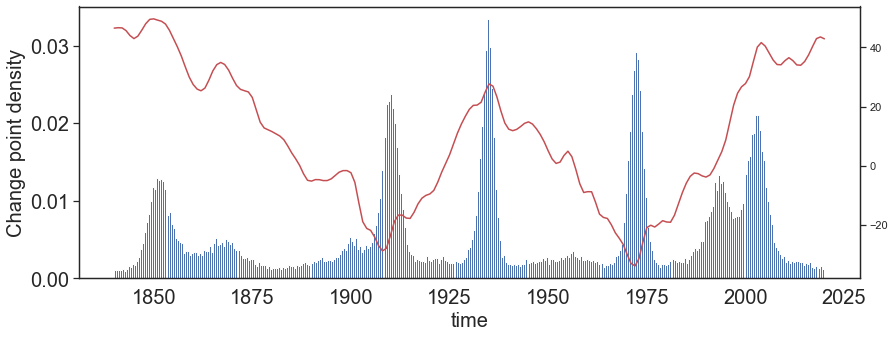

In [29]:
fig, ax = plt.subplots( figsize=(14,5))
marginal_counts, marginal_xedges, marginal_im = ax.hist( data_timing, bins=int(TIMES_MAX-TIMES_MIN)*2, range=[TIMES_MIN,TIMES_MAX],density=True)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('Change point density', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax1b = ax.twinx()
ax1b.plot(TIMES,Bx_dot,'r')


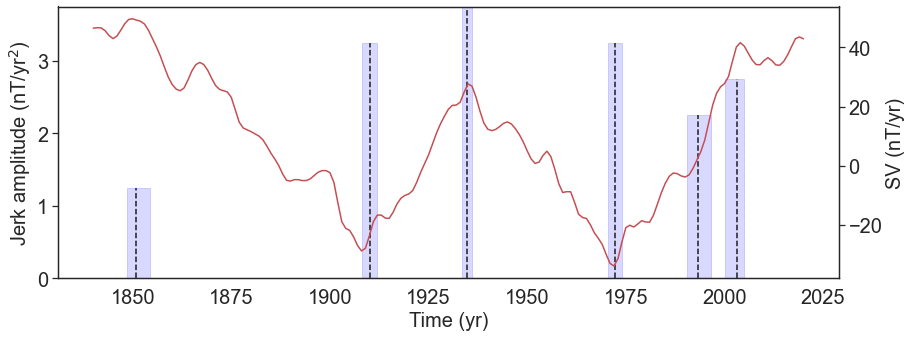

In [30]:
fig, ax = plt.subplots( figsize=(14,5))
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Jerk amplitude (nT/yr$^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax1b = ax.twinx()
ax1b.plot(TIMES,Bx_dot,'r')
ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
ax1b.tick_params(axis='y', which='major', labelsize=20)


ymin = 0
ymax = max(abs(jerk[1]) for jerk in jerks_info)
ax.set_ylim([ymin,ymax])
for jerk in jerks_info:
    ax.vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
    ax.fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
#plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


7 jerks found
Jerk 0 at time 1878.250000 with min/max of 1876.500000, 1880.000000
Jerk 1 at time 1897.250000 with min/max of 1896.000000, 1899.000000
Jerk 2 at time 1912.750000 with min/max of 1910.500000, 1916.500000
Jerk 3 at time 1939.750000 with min/max of 1938.500000, 1942.000000
Jerk 4 at time 1980.750000 with min/max of 1978.500000, 1983.000000
Jerk 5 at time 1989.750000 with min/max of 1988.500000, 1991.500000
Jerk 6 at time 2009.250000 with min/max of 2007.000000, 2012.000000


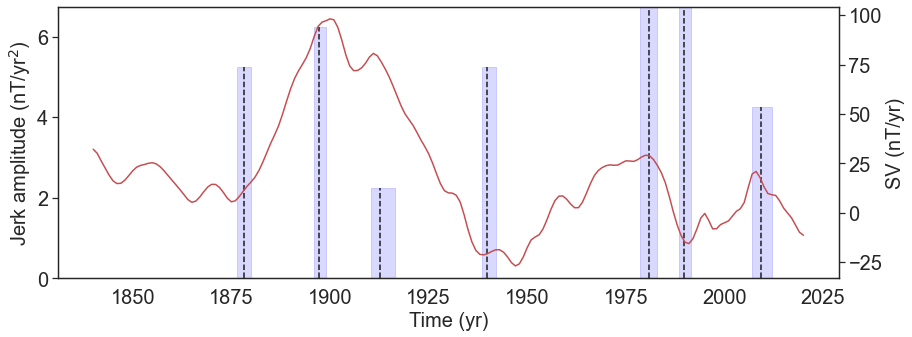

In [31]:
data_timing = jerk_data_save[0:size_jerk_data_save[1],0,1]
data_amplitude = jerk_data_save[0:size_jerk_data_save[1],1,1]
number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
number_amplitude_bins = 100
time_range = [TIMES_MIN,TIMES_MAX]
amplitude_range = [-30,30]
jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range, \
                        number_amplitude_bins=200, tau=0.60)
    
print('{0:d} jerks found'.format(len(jerks_info)) )
for index,jerk in enumerate(jerks_info):
      print('Jerk {0:d} at time {1:f} with min/max of {2:f}, {3:f}'.format(index,jerk[0], jerk[2], jerk[3]))
        

fig, ax = plt.subplots( figsize=(14,5))
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Jerk amplitude (nT/yr$^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax1b = ax.twinx()
ax1b.plot(TIMES,By_dot,'r')
ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
ax1b.tick_params(axis='y', which='major', labelsize=20)


ymin = 0
ymax = max(abs(jerk[1]) for jerk in jerks_info)
ax.set_ylim([ymin,ymax])
for jerk in jerks_info:
    ax.vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
    ax.fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
#plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


8 jerks found
Jerk 0 at time 8760.250000 with min/max of 8750.500000, 8766.500000
Jerk 1 at time 8816.750000 with min/max of 8810.500000, 8824.000000
Jerk 2 at time 8849.750000 with min/max of 8844.500000, 8857.000000
Jerk 3 at time 8878.250000 with min/max of 8876.500000, 8879.500000
Jerk 4 at time 8884.750000 with min/max of 8883.500000, 8886.500000
Jerk 5 at time 8904.250000 with min/max of 8901.500000, 8908.000000
Jerk 6 at time 8942.750000 with min/max of 8939.500000, 8946.500000
Jerk 7 at time 9066.250000 with min/max of 9062.500000, 9070.500000


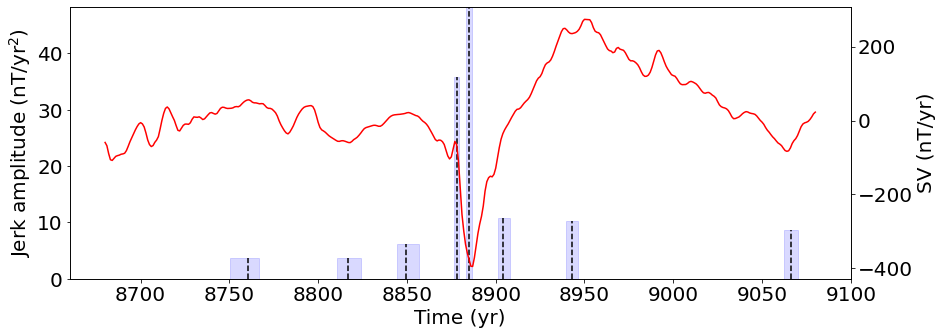

In [27]:
data_timing = jerk_data_save[0:size_jerk_data_save[2],0,2]
data_amplitude = jerk_data_save[0:size_jerk_data_save[2],1,2]
number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
number_amplitude_bins = 100
time_range = [TIMES_MIN,TIMES_MAX]
amplitude_range = [-30,30]
jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range, \
                        number_amplitude_bins=200, tau=0.60)
    
print('{0:d} jerks found'.format(len(jerks_info)) )
for index,jerk in enumerate(jerks_info):
      print('Jerk {0:d} at time {1:f} with min/max of {2:f}, {3:f}'.format(index,jerk[0], jerk[2], jerk[3]))
        

fig, ax = plt.subplots( figsize=(14,5))
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Jerk amplitude (nT/yr$^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax1b = ax.twinx()
ax1b.plot(TIMES,Bz_dot,'r')
ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
ax1b.tick_params(axis='y', which='major', labelsize=20)


ymin = 0
ymax = max(jerk[1] for jerk in jerks_info)
ax.set_ylim([ymin,ymax])
for jerk in jerks_info:
    ax.vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
    ax.fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
#plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

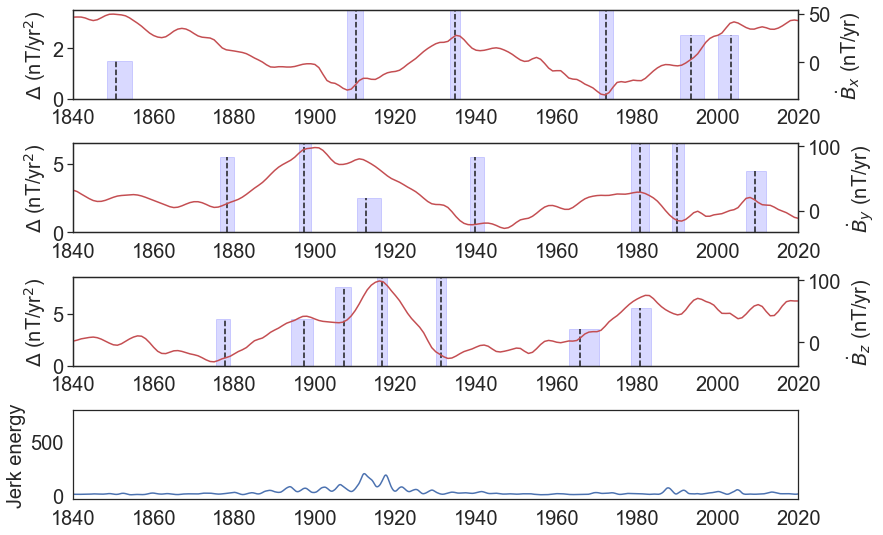

In [33]:
plt.figure()
ax=[0,1,2,3]
f, (ax[0], ax[1],ax[2],ax[3]) = plt.subplots(4, 1, figsize=(13,9) )

for cmpt in [0,1,2]:
    data_timing = jerk_data_save[0:size_jerk_data_save[cmpt],0,cmpt]
    data_amplitude = jerk_data_save[0:size_jerk_data_save[cmpt],1,cmpt]
    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range, \
                        number_amplitude_bins=100, tau=0.60)
    

    #ax[cmpt].set_xlabel('Time (yr)', fontsize=20)
    ax[cmpt].set_ylabel('$\Delta$ (nT/yr$^2$)', fontsize=20)
    ax[cmpt].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[cmpt].twinx()
    if cmpt == 0:
        axb.plot(TIMES,Bx_dot,'r')
        axb.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
    elif cmpt == 1:
        axb.plot(TIMES,By_dot,'r')
        axb.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
    else:
        axb.plot(TIMES,Bz_dot,'r')
        axb.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)

    #ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
    axb.tick_params(axis='y', which='major', labelsize=20)

    ax[cmpt].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info)
    ax[cmpt].set_ylim([ymin,ymax])
    for jerk in jerks_info:
        ax[cmpt].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[cmpt].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[3].plot(time_EJ, EJ )
ax[3].set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax[3].set_ylabel('Jerk energy',fontsize=20)
ax[3].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('COVOBS.x2.composite1.pdf')


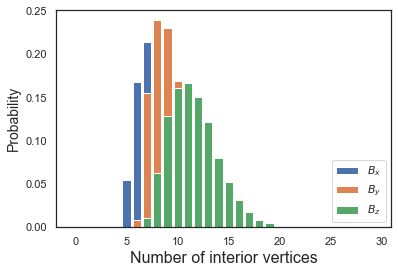

In [34]:
# Plot histogram of number of vertices
plt.figure()
plt.bar(np.arange(0,30),N_CP_hist_save[0:30,0]/np.sum(N_CP_hist_save[:,0]),align='center', label='$B_x$')
plt.bar(np.arange(0,30),N_CP_hist_save[0:30,1]/np.sum(N_CP_hist_save[:,1]),align='center', label='$B_y$')
plt.bar(np.arange(0,30),N_CP_hist_save[0:30,2]/np.sum(N_CP_hist_save[:,2]),align='center', label='$B_z$')
plt.legend(loc = 'lower right')

plt.xlabel('Number of interior vertices',fontsize=16)
plt.ylabel('Probability',fontsize=14)
plt.savefig('COVOBS_vertices.pdf',bbox_inches='tight')